In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt

In [2]:
data = requests.get("https://www.stat.cmu.edu/~larry/all-of-nonpar/=data/galaxy.dat", verify=False)
df = pd.read_csv(StringIO(data.text), sep="\s+", header=None, names=["ra", "declination", "redshift"])
redshift = df["redshift"]

D:\Code\jupyter\venv\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [3]:
print(len(redshift))

1425


## Histogram Estimator

In [4]:
def get_jh_hist(m, n, dat):
    yj = np.histogram(dat, bins=m)[0]
    pj = yj / n
    first = 2 * m / (n - 1)
    second = (n + 1) * m / (n - 1)
    third = np.sum(pj ** 2)
    return first - second * third

In [5]:
def get_jh_hist_all(dat):
    jh = []
    for i in range(len(dat)):
        jh.append(get_jh_hist(i + 1, len(dat), dat))
    return jh

In [6]:
jh_all = get_jh_hist_all(redshift)

In [7]:
np.min(jh_all)

-5.989204025439116

In [8]:
m_star = np.argmin(jh_all) + 1
m_star

597

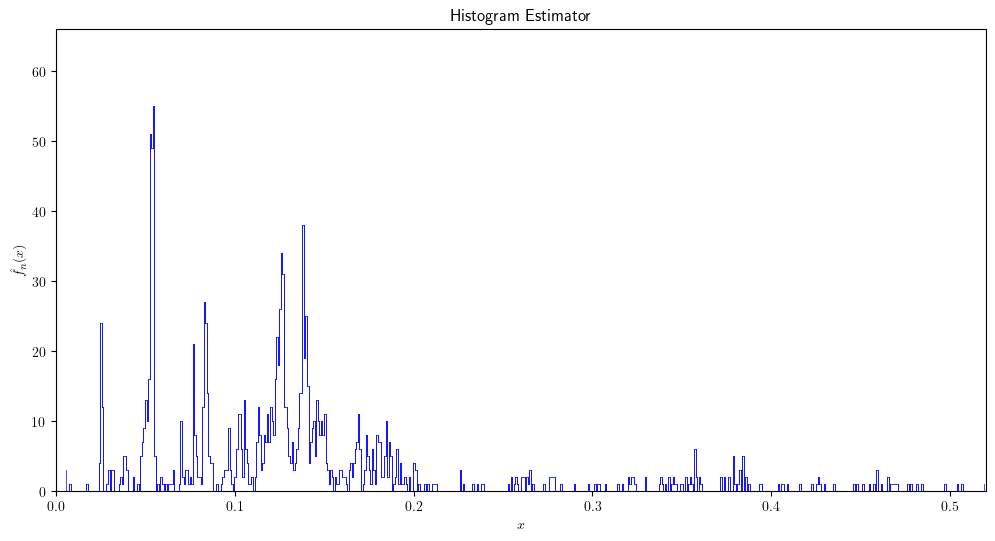

In [9]:
plt.rcParams["text.usetex"] = True
fig, ax = plt.subplots(figsize=(12, 6))
height = np.histogram(redshift, bins=m_star)[0]
x = (np.histogram(redshift, bins=m_star)[1])

for i in range(1, m_star-1):
    ax.add_line(plt.Line2D([x[i], x[i+1]], [height[i], height[i]], color='blue', linewidth=0.5))
    ax.add_line(plt.Line2D([x[i], x[i]], [height[i - 1], height[i]], color='blue', linewidth=0.5))
    ax.add_line(plt.Line2D([x[i+1], x[i+1]], [height[i], height[i + 1]], color='blue', linewidth=0.5))
ax.set_xlim(0, np.max(redshift))
ax.set_ylim(0, 1.2 * np.max(height))
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\hat{f_n}(x)$")
ax.set_title(r"Histogram Estimator")
plt.savefig("./fig/histogram_estimator.pdf")

## Kernel Estimator

In [10]:
def kernel_function(xx):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-xx ** 2 / 2)

def kernel_function_2(xx):
    return 1 / (2 * np.sqrt(2 * np.pi)) * np.exp(-xx ** 2 / 8)

def hat_f(xx, hx, dat):
    return 1 / len(dat) * np.sum(kernel_function((xx - dat) / hx) / hx)

datx, daty = np.meshgrid(redshift, redshift)
datx_x = datx - daty

def jh_kernel(hx, dat):
    n = len(dat)
    the_sum = np.sum(kernel_function_2(datx_x / hx) - 2 * kernel_function(datx_x / hx))
    the_jh = 1 / (hx * n ** 2) * the_sum + 2 / (hx * n * np.sqrt(2 * np.pi))
    return the_jh

In [11]:
step = 0.00005
hn = np.arange(step, 0.02, step)
jh = []
for i in hn:
    jh.append(jh_kernel(i, redshift))
jh = np.array(jh)

In [12]:
print(np.min(jh))
print(np.argmin(jh))
print((np.argmin(jh) + 1) * step)

-12.412517973369557
11
0.0006000000000000001


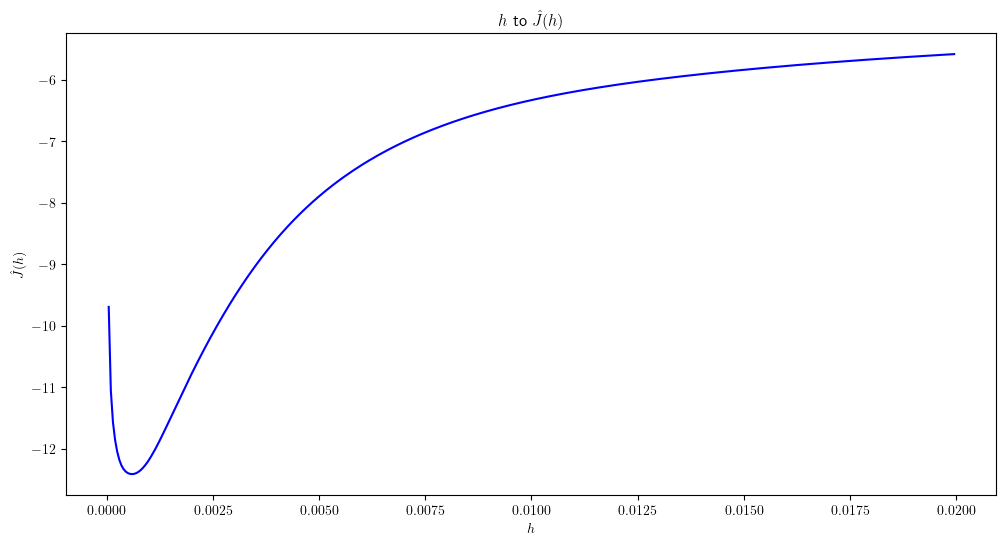

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(hn, jh, color="blue")
ax.set_xlabel(r"$h$")
ax.set_ylabel(r"$\hat{J}(h)$")
ax.set_title(r"$h$ to $\hat{J}(h)$")
plt.savefig("./fig/h_to_jh.pdf")

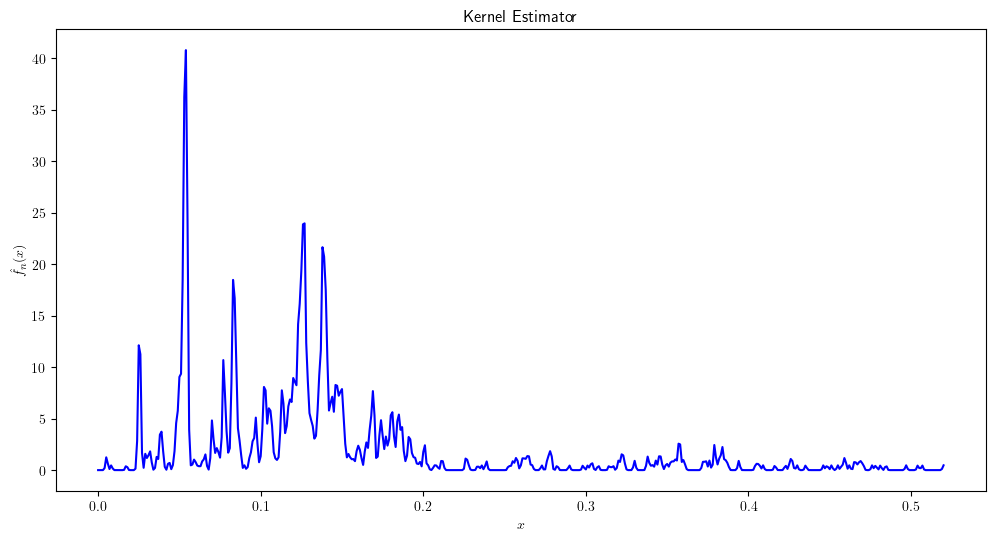

In [14]:
h_star = (np.argmin(jh) + 1) * step
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(0, np.max(redshift), 0.001)
y = []
for i in x:
    y.append(hat_f(i, h_star, redshift))
ax.plot(x, y, color="blue")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\hat{f_n}(x)$")
ax.set_title(r"Kernel Estimator")
plt.savefig("./fig/kernel_estimator.pdf")

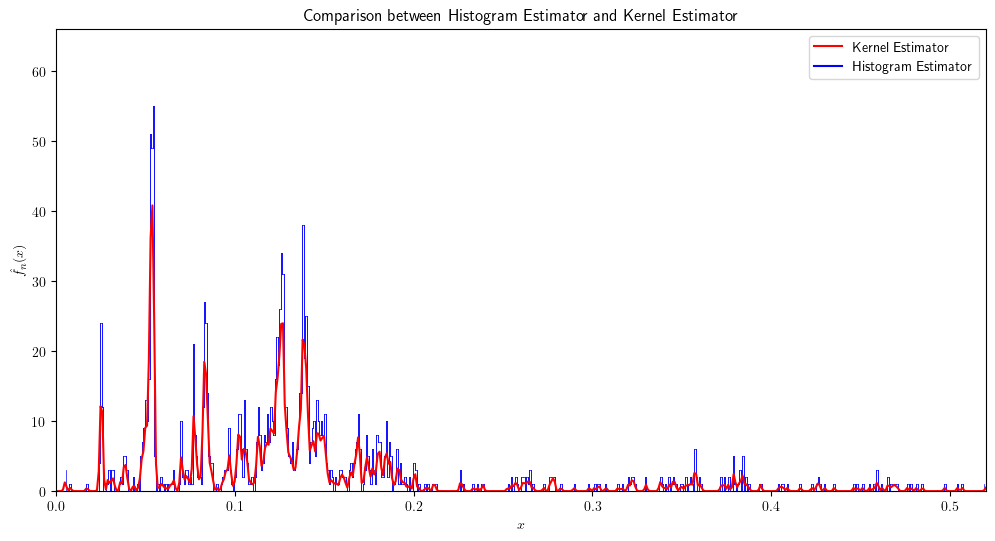

In [15]:
# Comparison between histogram estimator and kernel estimator
fig, ax = plt.subplots(figsize=(12, 6))
height = np.histogram(redshift, bins=m_star)[0]
x = (np.histogram(redshift, bins=m_star)[1])
x_k = np.arange(0, np.max(redshift), 0.001)
y_k = []
for i in x_k:
    y_k.append(hat_f(i, h_star, redshift))
for i in range(1, m_star-1):
    ax.add_line(plt.Line2D([x[i], x[i+1]], [height[i], height[i]], color='blue', linewidth=0.5))
    ax.add_line(plt.Line2D([x[i], x[i]], [height[i - 1], height[i]], color='blue', linewidth=0.5))
    ax.add_line(plt.Line2D([x[i+1], x[i+1]], [height[i], height[i + 1]], color='blue', linewidth=0.5))
ax.plot(x_k, y_k, color="red", label="Kernel Estimator")
ax.plot(0,0, color='blue', label="Histogram Estimator")
ax.set_xlim(0, np.max(redshift))
ax.set_ylim(0, 1.2 * np.max(height))
ax.legend()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\hat{f_n}(x)$")
ax.set_title(r"Comparison between Histogram Estimator and Kernel Estimator")
plt.savefig("./fig/histogram_and_kernel_estimator.pdf")

### Normal Reference

In [16]:
s = np.std(redshift)
iqr = np.quantile(redshift, 0.75) - np.quantile(redshift, 0.25)
h_norm = 1.06 * np.min([s, iqr / 1.34]) * len(redshift) ** (-1 / 5)
print(s, iqr / 1.34, h_norm)

0.0889070103989908 0.05297985074626865 0.0131417627598199


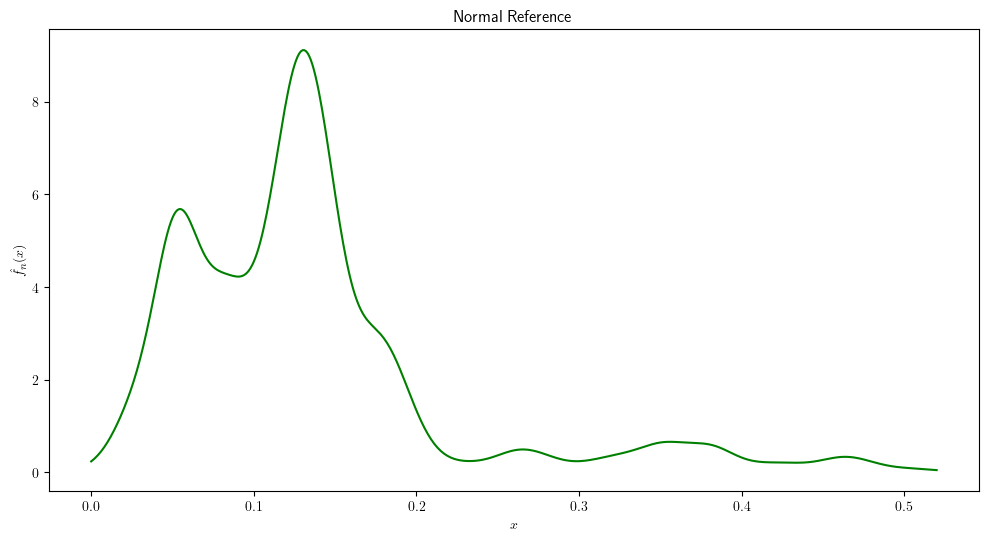

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
x_n = np.arange(0, np.max(redshift), 0.001)
y_n = []
for i in x_n:
    y_n.append(hat_f(i, h_norm, redshift))
ax.plot(x_n, y_n, color="green")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\hat{f_n}(x)$")
ax.set_title(r"Normal Reference")
plt.savefig("./fig/normal_reference.pdf")

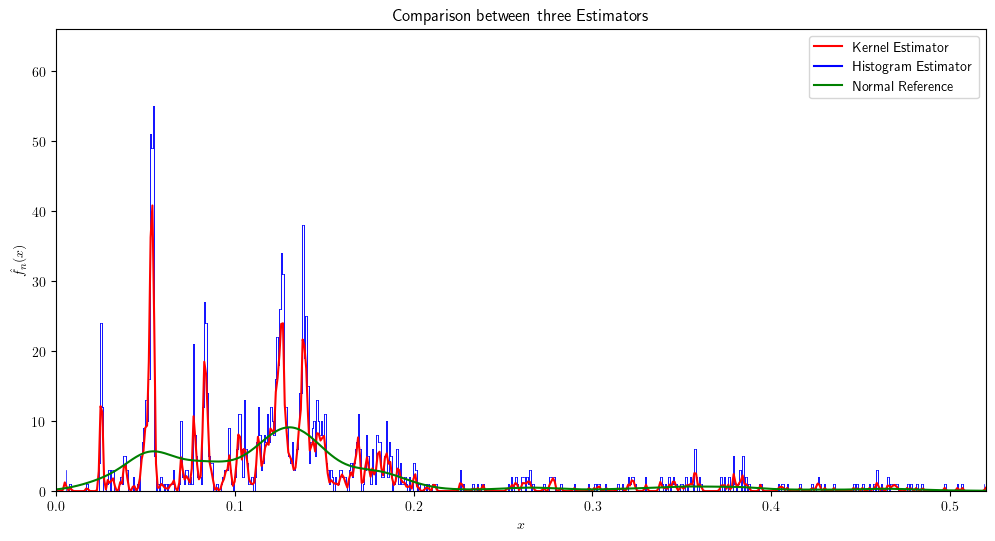

In [18]:
# Comparisons
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(1, m_star-1):
    ax.add_line(plt.Line2D([x[i], x[i+1]], [height[i], height[i]], color='blue', linewidth=0.5))
    ax.add_line(plt.Line2D([x[i], x[i]], [height[i - 1], height[i]], color='blue', linewidth=0.5))
    ax.add_line(plt.Line2D([x[i+1], x[i+1]], [height[i], height[i + 1]], color='blue', linewidth=0.5))
ax.plot(x_k, y_k, color="red", label="Kernel Estimator")
ax.plot(0,0, color='blue', label="Histogram Estimator")
ax.plot(x_n, y_n, color="green", label="Normal Reference")
ax.set_xlim(0, np.max(redshift))
ax.set_ylim(0, 1.2 * np.max(height))
ax.legend()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\hat{f_n}(x)$")
ax.set_title(r"Comparison between three Estimators")
plt.savefig("./fig/normal_reference_comp.pdf")